## Setup and Library Imports

Essential libraries for data manipulation, image processing, machine learning, and visualization.

In [2]:
import numpy as np
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import random

Random seeds are set to ensure reproducibility of results.

In [3]:
seed = 99
random.seed(seed)
np.random.seed(42)
tf.random.set_seed(42)

## Dataset

Kaggle link:  https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria/

**Content**
The dataset contains 2 folders:

- Parasitized
- Uninfected

And a total of 27,558 images.

**Acknowledgements**

This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

## Data Organization and Preprocessing

This cell organizes and preprocesses image data for a machine learning project:
- Path Definitions: Specifies paths for raw and processed data directories.
- Folder Creation: Generates necessary subdirectories within the processed data path for training, validation, and testing datasets, categorized by labels ('Uninfected' and 'Parasitized').
- Image Listing: Lists all images in the 'Uninfected' and 'Parasitized' categories from the raw data directory.
- Data Splitting: Utilizes an 80-10-10 split strategy to divide images into training, validation, and test sets. The train_test_split function from Scikit-learn is used to ensure reproducibility with a fixed random seed.
- File Copying: Copies images into their respective directories based on the split, ensuring that each dataset is organized correctly for model training and evaluation.

In [4]:
# Define paths
data_path = os.path.join('..', 'data', 'raw')
processed_path = os.path.join('..', 'data', 'processed')
folders = ['train', 'val', 'test']
labels = ['Uninfected', 'Parasitized']

# Create folders in processed_path
for folder in folders:
    for label in labels:
        os.makedirs(os.path.join(processed_path, folder, label), exist_ok=True)

# Create image lists
uninfected_images = [os.path.join(data_path, 'Uninfected', img) for img in os.listdir(os.path.join(data_path, 'Uninfected'))]
parasitized_images = [os.path.join(data_path, 'Parasitized', img) for img in os.listdir(os.path.join(data_path, 'Parasitized'))]

# Split
def split_and_copy(images, label):
    train, test = train_test_split(images, test_size=0.2, random_state=seed)  # 80% train, 20% temp
    val, test = train_test_split(test, test_size=0.5, random_state=seed)  # 10% val, 10% test

    # Move images to new folders
    for img in train:
        shutil.copy(img, os.path.join(processed_path, 'train', label))
    for img in val:
        shutil.copy(img, os.path.join(processed_path, 'val', label))
    for img in test:
        shutil.copy(img, os.path.join(processed_path, 'test', label))

# Execution for both classes
split_and_copy(uninfected_images, 'Uninfected')
split_and_copy(parasitized_images, 'Parasitized')


### Dataset Sample Count and Visualization

The first thing to do is to check if the three datasets are balanced in terms of positive and negative samples:

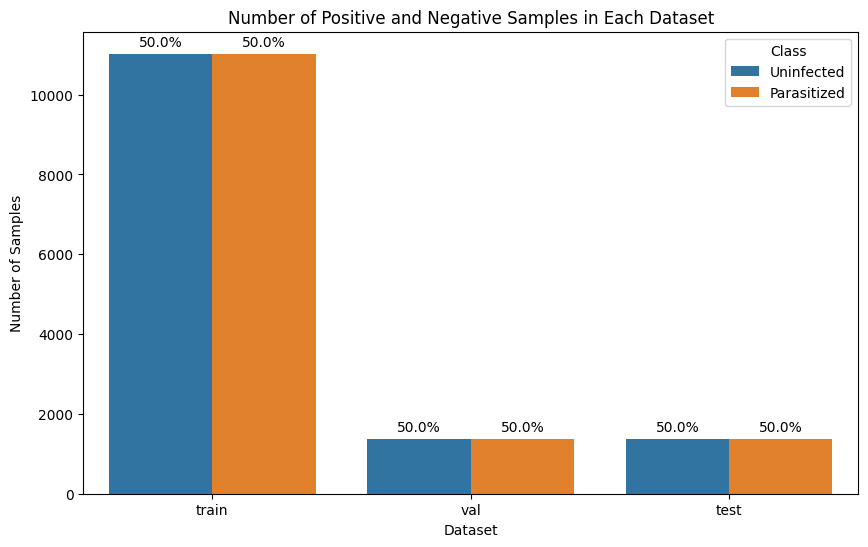

In [ ]:
# Counting samples in each set and class
data_counts = {'Dataset': [], 'Class': [], 'Count': []}

for dataset in folders:
    for label in labels:
        count = len(os.listdir(os.path.join(processed_path, dataset, label)))
        data_counts['Dataset'].append(dataset)
        data_counts['Class'].append(label)
        data_counts['Count'].append(count)

# Convert the data into a DataFrame
df = pd.DataFrame(data_counts)

# Calculate relative percentage
df['Total'] = df.groupby('Dataset')['Count'].transform('sum')
df['Percentage'] = (df['Count'] / df['Total'] * 100).round(2)

# Figure configuration
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Dataset', y='Count', hue='Class')

# Add percentages to the bars
for index, row in df.iterrows():
    plt.text(
        x=index // 2 + (index % 2) * 0.4 - 0.2,
        y=row['Count'] + max(df['Count']) * 0.01,
        s=f"{row['Percentage']}%",
        ha='center', va='bottom'
    )

# Titles and labels
plt.title('Number of Positive and Negative Samples in Each Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.legend(title='Class', loc='upper right')
plt.show()


There are exactly the same samples of uninfected cells as infected cells. Therefore, there is no need to balance the data sets.

### Representation

Let's represent some images of the train_set to get an idea of what they look like.

Uninfected


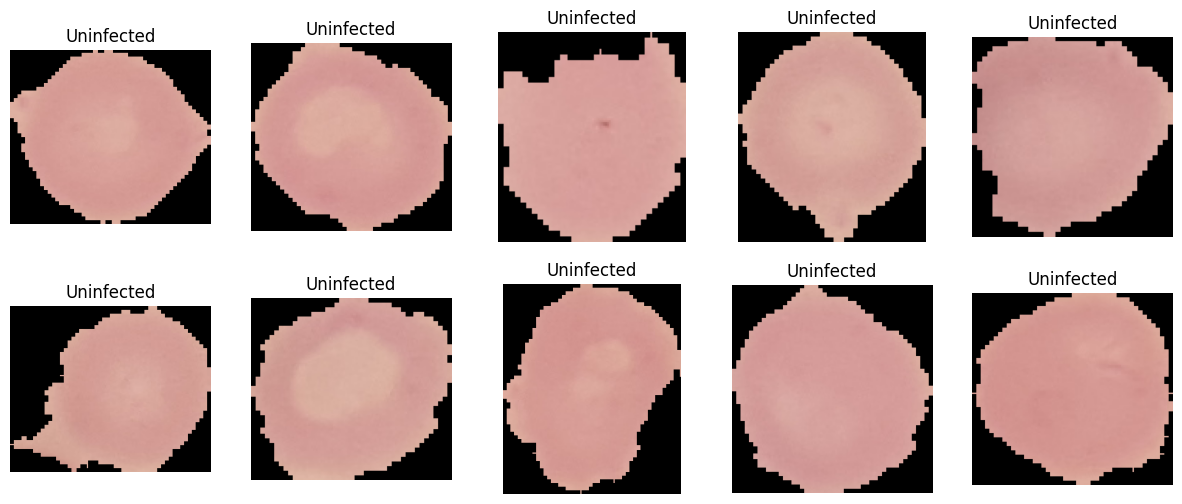

Parasitized


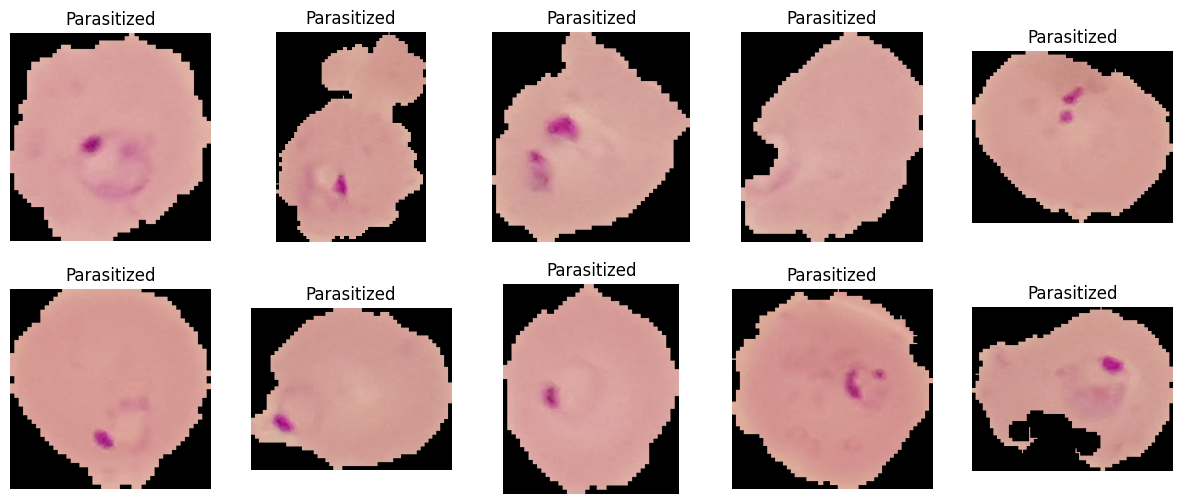

In [ ]:
# Training folder paths for each class
train_path_uninfected = os.path.join('..', 'data', 'processed', 'train', 'Uninfected')
train_path_parasitized = os.path.join('..', 'data', 'processed', 'train', 'Parasitized')

# Function to load and display images in multiple rows
def show_sample_images_grid(paths, title, n_rows=2, n_cols=5):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(paths[:n_rows * n_cols]):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display with matplotlib
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

# Obtain some image paths for each class
uninfected_images = [os.path.join(train_path_uninfected, img) for img in os.listdir(train_path_uninfected)[:10]]
parasitized_images = [os.path.join(train_path_parasitized, img) for img in os.listdir(train_path_parasitized)[:10]]

# Show examples of uninfected and parasitized images
print("Uninfected")
show_sample_images_grid(uninfected_images, title='Uninfected', n_rows=2, n_cols=5)
print("Parasitized")
show_sample_images_grid(parasitized_images, title='Parasitized', n_rows=2, n_cols=5)


### Image Aspect Ratio Analysis

It can be seen that each one has a different size and height/width ratio. However, in all of them the cells occupy the whole image. Therefore, it will not be necessary to perform cropping operations with OpenCV such as calculating contours, endpoints and enlarging the images.

We check the different height/width ratios:

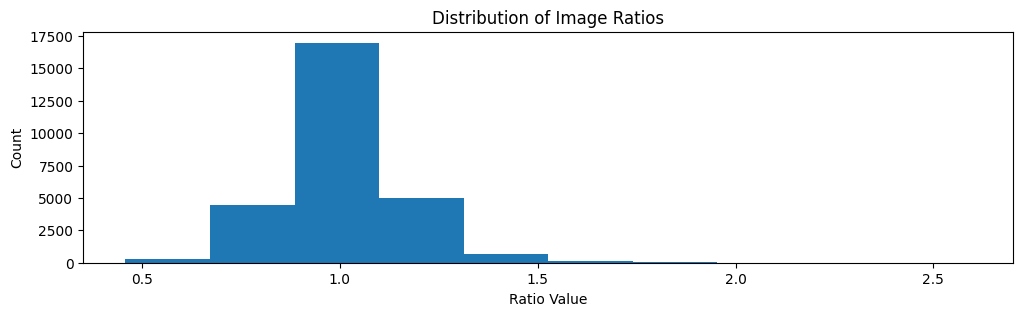

In [ ]:
RATIO_LIST = []
for folder in folders:  # train, val and test
    for label in labels:  # Uninfected and Parasitized
        img_paths = os.path.join(processed_path, folder, label)
        for img_path in os.listdir(img_paths):
            if img_path.endswith('png'):
                img = cv2.imread(os.path.join(img_paths, img_path))
                RATIO_LIST.append(img.shape[1] / img.shape[0])

plt.figure(figsize=(12, 3))
plt.hist(RATIO_LIST, bins=10)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

## Model Definition and Compilation
Convolutional Neural Network (CNN) is defined using transfer learning with the MobileNetV2 architecture:

- **Directory Paths**: Defines paths for training, validation, and test datasets within the processed data directory.

- **Parameters**:
    - IMG_SIZE: Specifies the input image size for the CNN, set to 100x100 pixels.
    - batch_size: Sets the batch size for model training, defined as 32.

- **Base Model**:
Utilizes MobileNetV2 from Keras applications with pre-trained weights on ImageNet.
The top classification layer is excluded (include_top=False) to allow customization for binary classification.
The base model's layers are frozen (trainable=False) to retain learned features during initial training.

- **Model Architecture**:
A sequential model is created by stacking layers on top of the base model.
Includes a flattening layer, dropout layers for regularization, and dense layers for classification.
The final dense layer uses a sigmoid activation function suitable for binary classification tasks.

- **Model Compilation**:
Compiled with the Adam optimizer and a learning rate of 0.0002.
Uses binary crossentropy as the loss function and accuracy as a performance metric.

In [ ]:
# Define data paths
base_dir = os.path.join('..', 'data', 'processed')  # Base path for the processed data set
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
IMG_SIZE = 100  # Input size for CNN
batch_size = 32

# Pre-trained CNN
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# Freeze the base model layers
base_model.trainable = False

# Create the complete model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),  # Dense trainable layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Dense final layer with sigmoid activation for binary classification
])

# Model compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

C:\Users\anton\AppData\Local\Temp\ipykernel_41544\334681801.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       655,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,913,409 (11.11 MB)

 Trainable params: 655,425 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Data Augmentation and Generator Setup
This cell prepares data generators for training and validation using Keras' ImageDataGenerator:
- **Data Augmentation for Training**:
    - Rescaling: Normalizes pixel values to a range of 0 to 1.
    - Transformations: Applies random transformations to enhance model robustness, including:
        - Rotation, width/height shifts, shear, and zoom.
        - Horizontal and vertical flips.
        - Brightness adjustments.
    - Fill Mode: Uses 'nearest' to fill in pixels after transformations.

- **Validation Data Preparation**:
Rescaling Only: Normalizes pixel values without augmentation to evaluate model performance on unaltered data.

- **Data Generators**:
    - Training Generator: Loads images from the training directory, applies augmentations, and outputs batches for training.
    - Validation Generator: Loads images from the validation directory, rescaled without augmentations, for model validation.

These generators facilitate efficient loading and preprocessing of images during model training.

In [ ]:
# Crear generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,  # Normalización ya incluida en el modelo
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Crear generadores de datos
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
)

Found 22048 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


### Model Training with Early Stopping

Training of the CNN model with early stopping to prevent overfitting:

- **Epochs**: Sets the number of training epochs to 20, allowing the model multiple iterations over the dataset.

- **Early Stopping Callback**:
    - Monitor: Observes the validation accuracy to determine when to stop training.
    - Mode: Set to 'max' to maximize validation accuracy.
    - Patience: Stops training if validation accuracy does not improve for 3 consecutive epochs.
    - Verbose: Provides updates in the console about early stopping events.

- **Model Training**:
    - Uses the fit method to train the model with data from train_generator.
    - Validates performance using val_generator.
    - Incorporates early stopping to halt training once improvements plateau, conserving resources and potentially enhancing model generalization.

The history object captures training dynamics, such as loss and accuracy trends, which are analyzed post-training.

In [ ]:
epochs = 20

# Early stopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=2,
    verbose=1,
)

# Training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[es],
)

model.save(os.path.join('..', 'models', 'model.keras'))

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 91s 132ms/step - accuracy: 0.9332 - loss: 0.1901 - val_accuracy: 0.9488 - val_loss: 0.1430
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 101s 147ms/step - accuracy: 0.9362 - loss: 0.1879 - val_accuracy: 0.9503 - val_loss: 0.1453
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 112s 163ms/step - accuracy: 0.9317 - loss: 0.1937 - val_accuracy: 0.9470 - val_loss: 0.1478
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 0.9331 - loss: 0.1916 - val_accuracy: 0.9496 - val_loss: 0.1439
Epoch 4: early stopping


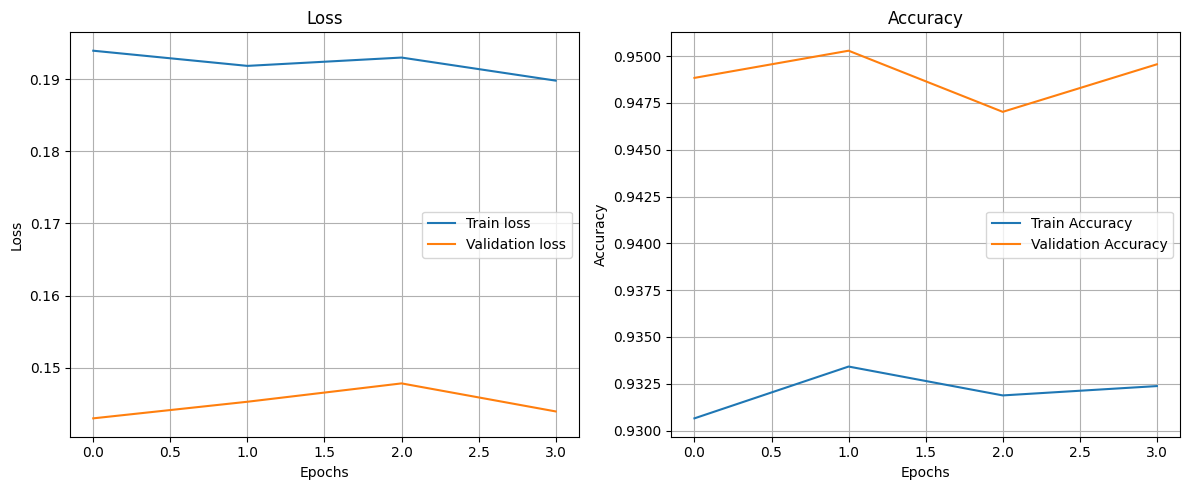

In [14]:
# Plotting the loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## **Model Evaluation on Validation Data**

Evaluation of the trained model's performance on the validation dataset, using a threshold of 0.5 for classification:

- **Validation Generator**:
  - Configured with `shuffle=False` to ensure predictions align with true labels.
  - Reset to start from the beginning of the dataset, ensuring consistency in evaluation.

- **Predictions**:
  - The model predicts probabilities for each validation sample.
  - Probabilities are converted to binary class predictions using a threshold of 0.5.

- **Confusion Matrix**:
  - Computed using true labels (`y_true`) and predicted labels (`y_pred`).
  - Visualized as a heatmap with Seaborn, providing insights into the model's classification performance.

- **Performance Metrics**:
  - **Accuracy**: Proportion of correctly classified samples.
  - **Precision**: Ratio of true positive predictions to all positive predictions.
  - **Recall**: Ratio of true positive predictions to all actual positives.

- **Focus on Precision**:
  - The goal is to minimize false negatives (uninfected classified as parasitized).
  - Since the generator assigns label 0 to 'Parasitized' and 1 to 'Uninfected' (alphabetical order), maximizing precision is crucial.
  - Increasing the binarization threshold can help achieve higher precision by reducing false positives.

- **Visualization and Output**:
  - The confusion matrix heatmap is displayed with class labels ('Parasitized' and 'Uninfected').
  - Prints accuracy, precision, and recall to summarize model performance on validation data.

This evaluation helps assess how well the model generalizes to unseen data and identifies areas for potential improvement. Adjustments to the classification threshold can be explored.

Found 2756 images belonging to 2 classes.


c:\Users\anton\anaconda3\envs\Capgemini_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


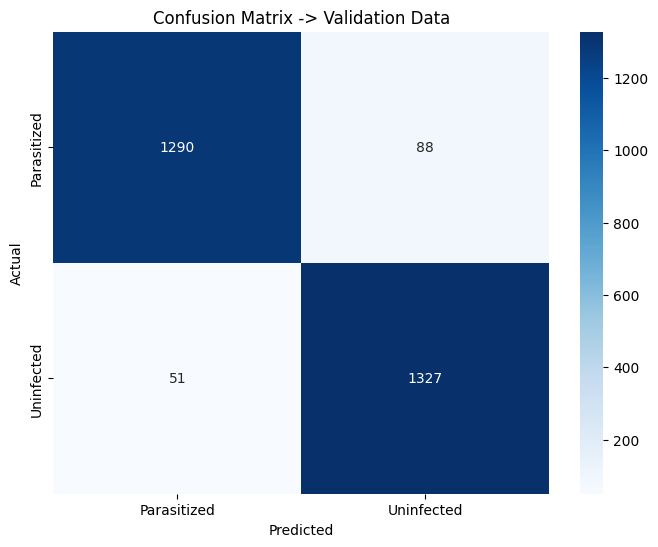

Test data metrics:
Accuracy: 0.95
Precision: 0.94
Recall: 0.96


In [15]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
    shuffle=False  # Important in order to correctly match predictions to actual samples
)
val_generator.reset()  # Restart the generator to make sure it starts from the beginning.
predictions = model.predict(val_generator)
y_true = val_generator.classes  # Actual labels
y_pred = (predictions > 0.5).astype(int).flatten()  # Threshold of 0.5 to convert probabilities to classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.title('Confusion Matrix -> Validation Data')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Test data metrics:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

This cell evaluates the model's performance on the validation dataset using an increased classification threshold of 0.8 to enhance precision:

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


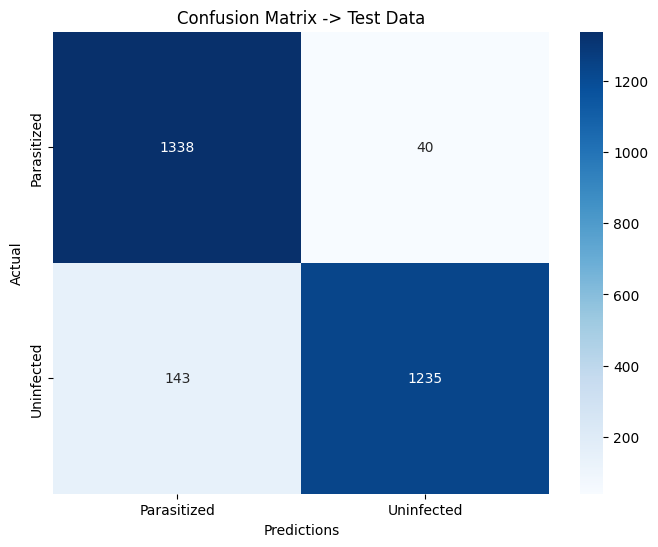

Test data metrics:
Accuracy: 0.93
Precision: 0.97
Recall: 0.90


In [ ]:
val_generator.reset()  # Restart the generator to make sure it starts from the beginning.
predictions = model.predict(val_generator)
y_true = val_generator.classes
y_pred = (predictions > 0.8).astype(int).flatten()  # Threshold of 0.8 to convert probabilities to classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.title('Confusion Matrix -> Test Data')
plt.ylabel('Actual')
plt.xlabel('Predictions')
plt.show()

print('Test data metrics:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

As we can see, the precision has increased so that it is less likely to classify a parasitized sample as uninfected.

Let's check the model metrics on the unseen test data.

In [ ]:
# Obtain the actual labels and predictions of the test set
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',  # {'Parasitized': 0, 'Uninfected': 1} alphabetical order
    seed=seed,
    shuffle=False
)

test_generator.reset()
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = (predictions > 0.8).astype(int).flatten()  # Threshold of 0.8 to convert probabilities to classes

Found 2754 images belonging to 2 classes.


c:\Users\anton\anaconda3\envs\Capgemini_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step


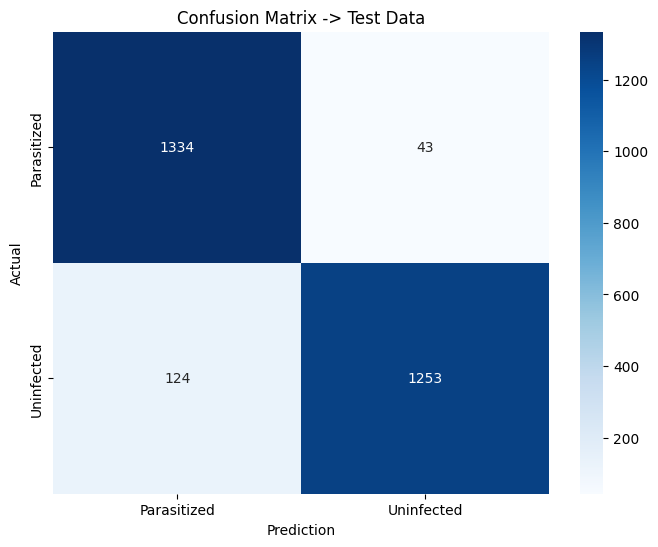

Test data metrics:
Accuracy: 0.94
Precision: 0.97
Recall: 0.91


In [18]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.title('Confusion Matrix -> Test Data')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.show()

print('Test data metrics:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

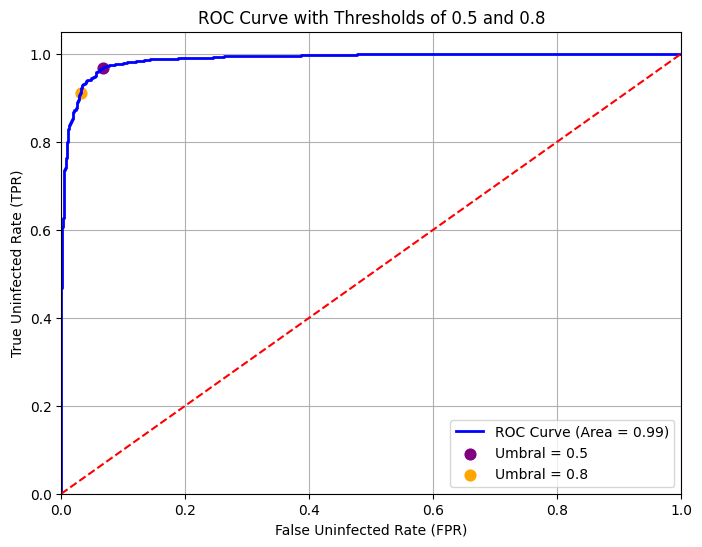

In [19]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Identify the coordinates of the 0.5 and 0.8 thresholds.
threshold_05_index = (np.abs(thresholds - 0.5)).argmin()
threshold_08_index = (np.abs(thresholds - 0.8)).argmin()

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (Area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.scatter(fpr[threshold_05_index], tpr[threshold_05_index], color='purple', label='Umbral = 0.5', s=60)
plt.scatter(fpr[threshold_08_index], tpr[threshold_08_index], color='orange', label='Umbral = 0.8', s=60)

# Configure axes and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Uninfected Rate (FPR)')
plt.ylabel('True Uninfected Rate (TPR)')
plt.title('ROC Curve with Thresholds of 0.5 and 0.8')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## **Conclusions**

- **High Accuracy**: The model achieves an accuracy of 94%, indicating that it correctly classifies a large proportion of the test data.

- **Precision and Recall**: 
  - **Precision (0.97)**: This high precision suggests that when the model predicts 'Uninfected', it is correct 97% of the time, reducing false uninfected rate (parasitized classified as uninfected).
  - **Recall (0.91)**: The recall does not decrease much with the change in the threshold.

- **ROC Curve Analysis**:
  - The ROC curve shows a high area under the curve (AUC) of 0.99, which reflects excellent model performance in distinguishing between 'Parasitized' and 'Uninfected' classes.
  - The plot includes thresholds of 0.5 and 0.8, demonstrating how different thresholds impact the trade-off between true positive rate (TPR) and false positive rate (FPR).

### **Overall Assessment**

The model performs exceptionally well with both high precision and recall, achieving a strong balance between minimizing false uninfected and maintaining sensitivity to true uninfected. The ROC curve further confirms its robustness in classification tasks, making it suitable for applications where accurate identification of parasitized cases is critical. Adjusting the threshold to 0.8 has successfully increased precision while maintaining a high level of recall, aligning with the objectives.

## flake8 linter

Use of flake8 to ensure code quality and adherence to Python's PEP 8 style guide across scripts and Jupyter notebooks.

In [14]:
!cd .. & flake8 ./

In [19]:
!cd .. & nbqa flake8 ./